In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
from typing import Dict

In [19]:
import sys
sys.path.append("../")

In [20]:
import constants
from core.tools.metrics import *
from core.models.stat_models import *
from core.models.baseline_rnn import *
from core.tools.visualize import *
from core.tools.time_series import *
from core.tools.data_import import *
import core.models.baseline_lstm as baseline_lstm

In [21]:
# Avaiable datasets, loaded from constants.
pprint(constants.DATA_DIR)
choice = None
while choice is None or choice not in constants.DATA_DIR.keys():
    if choice is not None:
        print("Invalid data location received, try again...")
    choice = input("Select Dataset >>> ")
FILE_DIR = constants.DATA_DIR[choice]

{'0': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv',
 '1': '/home/ec2-user/AnnEconForecast/data/UNRATE.csv',
 '2': '/home/ubuntu/AnnEconForecast/data/UNRATE.csv',
 '3': '/home/ec2-user/AnnEconForecast/data/DEXCAUS.csv'}
Select Dataset >>> 1


In [22]:
print(f"Dataset chosen: \n{FILE_DIR}")

Dataset chosen: 
/home/ec2-user/AnnEconForecast/data/UNRATE.csv


In [23]:
# Pre-processing Parameters
PERIODS = 1
ORDER = 1
LAGS = 12
TRAIN_RATIO = 0.8

In [24]:
# # Neural Network Parameters
# NUM_TIME_STEPS = LAGS
# # Number of series used to predict. (including concurrent)
# NUM_INPUTS = 1
# NUM_OUTPUTS = 1
# NUM_NEURONS = 64
# # Number of output series
# LEARNING_RATE = 0.01
# EPOCHS = 50
# # Training Settings
# REPORT_PERIODS = 1
# TENSORBOARD_DIR = "./tensorboard/test/1"

In [25]:
EXPERIMENT_NAME = "ec2-demo"

In [47]:
# Main Training Parameters
parameters = {
    "epochs": 500,
    "num_time_steps": LAGS,
    "num_inputs": 1,
    "num_outputs": 1,
    "num_neurons": 512,
    "learning_rate": 0.01,
    "report_periods": 10,
    "tensorboard_dir": f"/home/ec2-user/AnnEconForecast/tensorboard/{EXPERIMENT_NAME}",
    "model_path": f"/home/ec2-user/AnnEconForecast/saved_models/{EXPERIMENT_NAME}/my_model"
}

In [48]:
prepared_df = baseline_lstm.prepare_dataset(
    file_dir=FILE_DIR,
    periods=PERIODS,
    order=ORDER
)

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64
First few rows of dataset loaded:
            UNRATE_period1_order1
DATE                             
1948-02-01                    0.4
1948-03-01                    0.2
1948-04-01                   -0.1
1948-05-01                   -0.4
1948-06-01                    0.1


In [49]:
# Normalize data
(X_train, X_val, X_test,
 y_train, y_val, y_test) = baseline_lstm.normalize(
    df=prepared_df,
    train_ratio=TRAIN_RATIO,
    lags=LAGS
)

Total 836 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (836, 12, 1), y shape = (836, 1, 1)
Training and testing set generated,        
X_train shape: (601, 12, 1)        
y_train shape: (601, 1)        
X_test shape: (168, 12, 1)        
y_test shape: (168, 1)        
X_validation shape: (67, 12, 1)        
y_validation shape: (67, 1)


In [50]:
data_collection = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test
}

In [51]:
checkpoints = lambda z: [z*x for x in range(1, parameters["epochs"]//z)] + [-1]

In [52]:
# Run the model
(metrics_dict, predictions) = baseline_lstm.exec_core(
    parameters=parameters,
    data_collection=data_collection,
    clip_grad=None,
    prediction_checkpoints=checkpoints(50)
)

Resetting Tensorflow defalut graph...
Note: no gradient clipping is applied.            
If possible gradient exploding detected (e.g. nan loss), try use clip_grad.

Iteration [0], Training MSE 6182.4912109; Validation MSE 1607.1253662

Iteration [100], Training MSE 0.9907596; Validation MSE 0.3237351

Iteration [200], Training MSE 0.8641198; Validation MSE 0.3175822

Iteration [300], Training MSE 0.8146186; Validation MSE 0.3156954

Iteration [400], Training MSE 0.7833562; Validation MSE 0.3150887
Saving the trained model...
Time taken for [500] epochs:  0:00:13.585887
Loss Summary:
	mae=0.5762012004852295
	mse=0.5193581581115723
	rmse=0.7206650972366333
	mape=5.270551681518555


In [55]:
# plt.close()
# plt.figure(figsize=(32, 16))
# plt.plot(predictions[1000]["train"].reshape(-1, 1), alpha=0.6)
# plt.plot(y_train.reshape(-1, 1), alpha=0.6)
# plt.legend(["Training Prediction", "Training Actual"])
# plt.grid(True)
# plt.title("Training Set Result")
# plt.show()

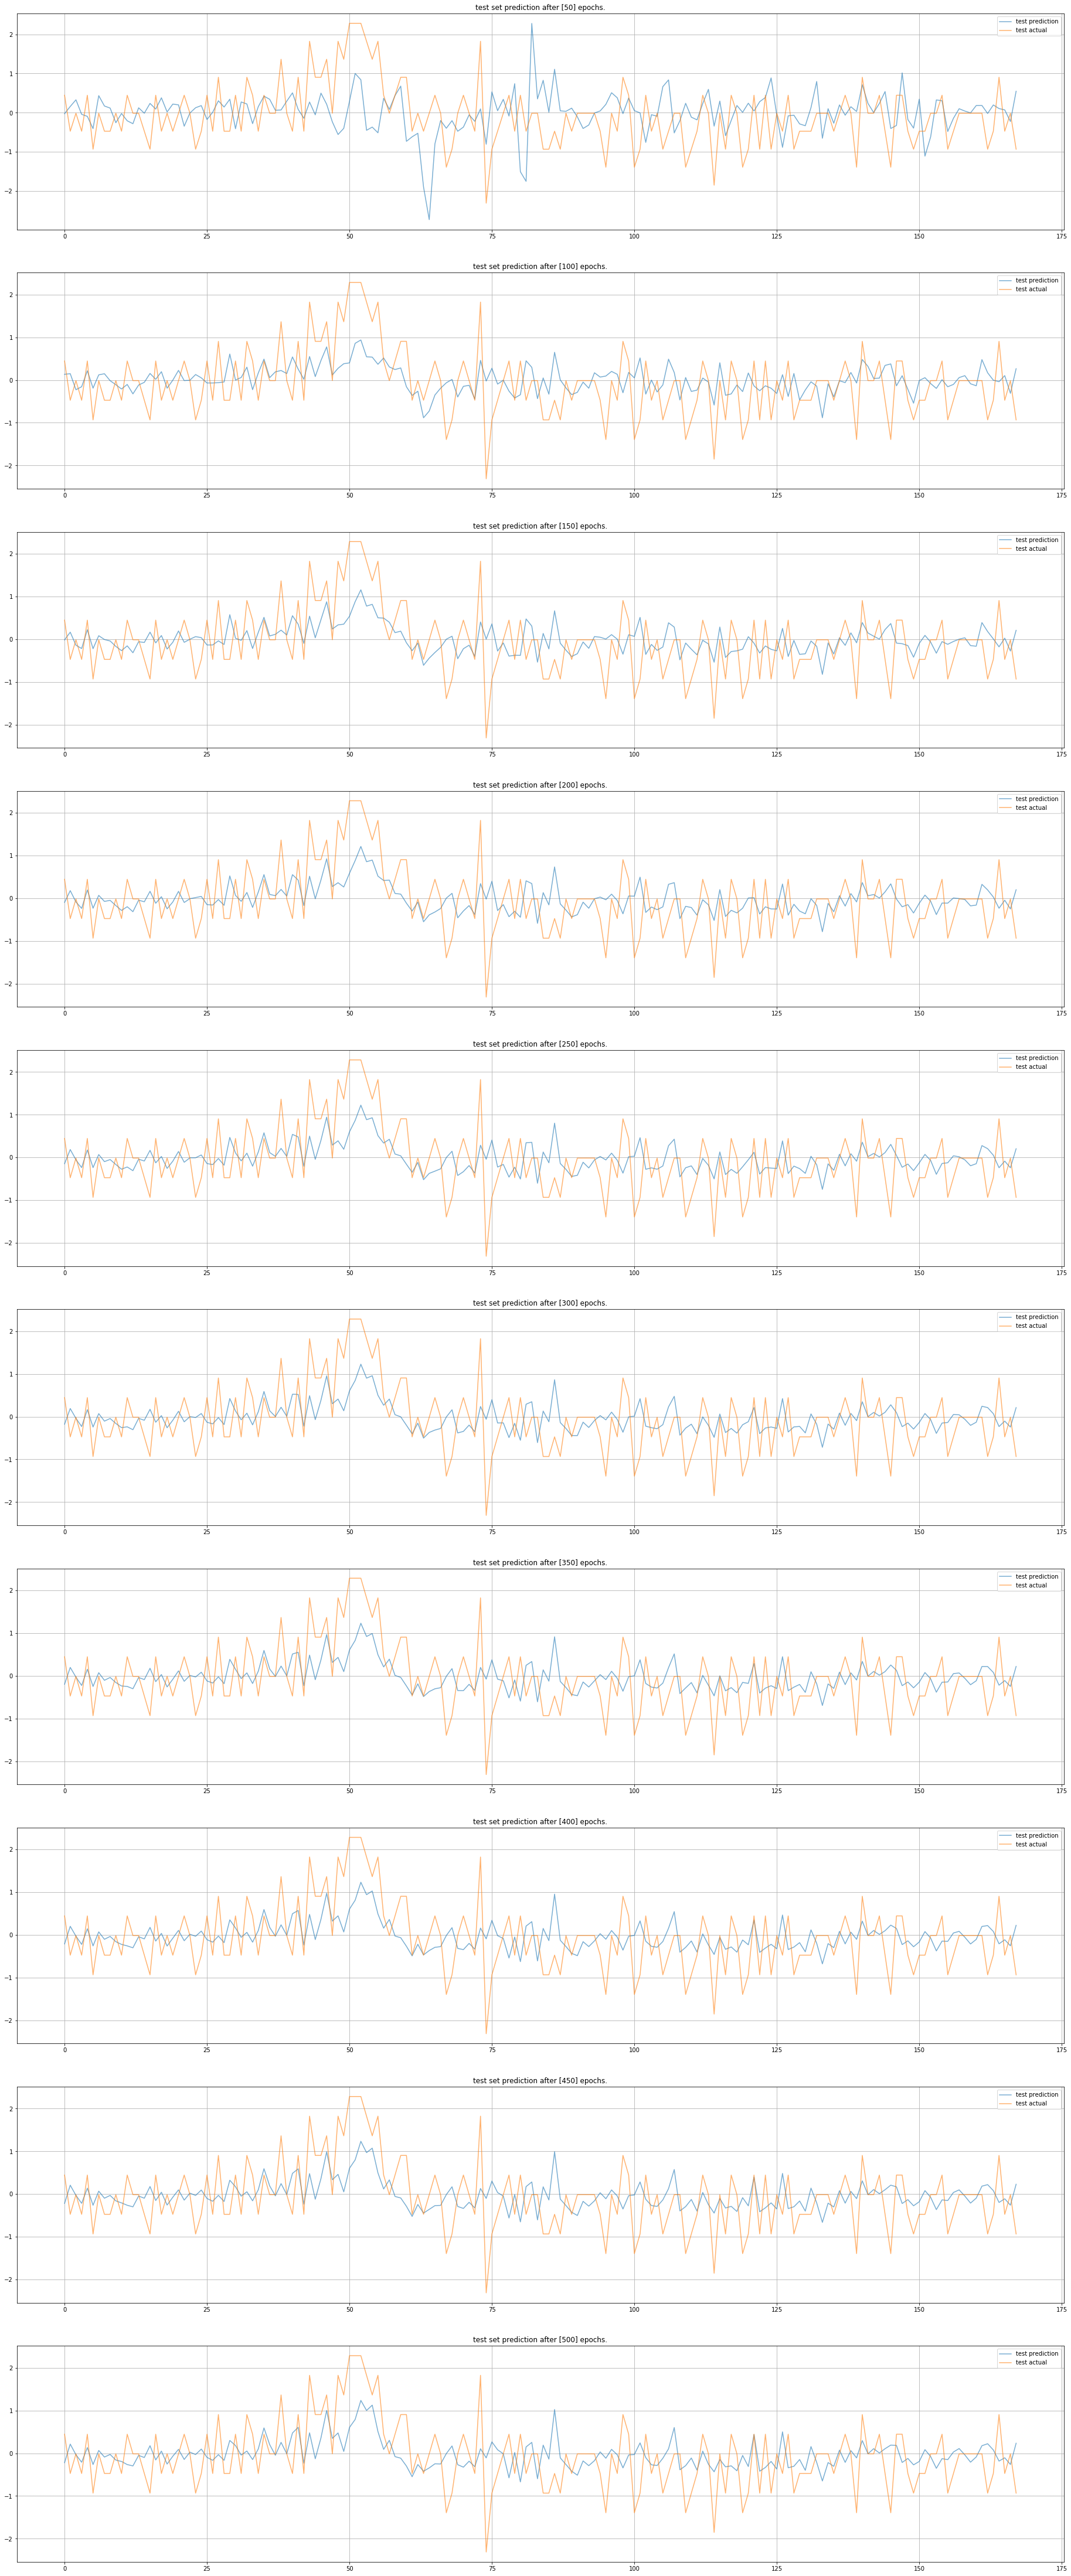

In [56]:
def plot_checkpoints(
    predictions: Dict[int, Dict[str, np.ndarray]],
    actual: np.ndarray,
    key: str
):
#     width = np.ceil(np.sqrt(len(predictions))).astype(int)
    f, axarr = plt.subplots(
        len(predictions.keys()),
        sharex=False,
        sharey=False,
        figsize=(32,8*len(predictions.keys())))
    for i, e in enumerate(predictions.keys()):
        pred = predictions[e]
        axarr[i].plot(pred[key].reshape(-1,1), alpha=0.6)
        axarr[i].plot(actual.reshape(-1, 1), alpha=0.6)
        axarr[i].set_title(f"{key} set prediction after [{e}] epochs.")
        axarr[i].legend([f"{key} prediction", f"{key} actual"])
        axarr[i].grid(True)
    return f, axarr
fig = plot_checkpoints(predictions, y_test, "test")

In [17]:
# plt.close()
# plt.figure(figsize=(32, 16))
# plt.plot(predictions[100]["test"].reshape(-1, 1), alpha=0.6)
# plt.plot(y_test.reshape(-1, 1), alpha=0.6)
# plt.legend(["Testing Prediction", "Testing Actual"])
# plt.grid(True)
# plt.title("Testing Set Result")
# plt.show()